In [1]:
from train_mmm import TrainMMM
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from hyperopt import fmin, tpe, hp, Trials

# Import data

In [2]:
df = pd.read_csv("mmm_training_data.csv")
df['week_ending'] = pd.to_datetime(df['week_ending'])
df = df.sort_values(by=["week_ending"]).reset_index(drop=True)
df

,week_ending,spend_ppc_nb,spend_ppc_b,spend_social,imp_ppc_nb,imp_ppc_b,imp_social,clk_ppc_nb,clk_ppc_b,clk_social,imp_seo,clk_seo,demand,conversions
0,2021-01-03,5249.82,8892.61,23654.36,3841530,8483,3213265,30387,4083,10547,181049,11751,72,1989
1,2021-01-10,6559.41,14710.67,51764.77,5420719,18277,5141459,42216,8688,15238,149213,10177,71,1807
2,2021-01-17,4480.64,15685.86,54968.74,3494441,17614,4522178,28825,7966,14145,143316,10403,73,1833
3,2021-01-24,3566.58,18022.25,52360.92,3183709,19794,4349616,30769,8855,12718,149786,11043,75,1921
4,2021-01-31,13171.17,19528.00,147908.35,2778447,21906,10410231,20068,9264,22942,173740,12672,71,2341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-04-28,106030.07,21209.89,53475.76,200121,32170,14768637,4633,13937,30539,621504,55942,81,2247
174,2024-05-05,137776.76,21601.90,52552.17,268167,35102,15388683,7767,15484,29904,667976,60592,78,2688
175,2024-05-12,78721.38,17308.82,56726.01,226918,33357,18650946,6159,15072,27541,656537,55458,72,2058
176,2024-05-19,60470.16,17172.98,47983.05,178135,31592,10310526,3709,14775,14892,623004,54486,76,1729


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   week_ending   178 non-null    datetime64[ns]
 1   spend_ppc_nb  178 non-null    float64       
 2   spend_ppc_b   178 non-null    float64       
 3   spend_social  178 non-null    float64       
 4   imp_ppc_nb    178 non-null    int64         
 5   imp_ppc_b     178 non-null    int64         
 6   imp_social    178 non-null    int64         
 7   clk_ppc_nb    178 non-null    int64         
 8   clk_ppc_b     178 non-null    int64         
 9   clk_social    178 non-null    int64         
 10  imp_seo       178 non-null    int64         
 11  clk_seo       178 non-null    int64         
 12  demand        178 non-null    int64         
 13  conversions   178 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 19.6 KB


# EDA

In [4]:
features = ["spend_ppc_nb",
            "spend_ppc_b",
            "spend_social",
            "imp_seo",
            "demand"]

target = "conversions"

X = df[features].values
y = df[target].values

correlation_matrix = df[features + [target]].corr()
correlation_matrix

,spend_ppc_nb,spend_ppc_b,spend_social,imp_seo,demand,conversions
spend_ppc_nb,1.000000,0.511271,0.649787,0.633297,0.352806,0.766770
spend_ppc_b,0.511271,1.000000,0.491790,0.520660,0.281470,0.465827
spend_social,0.649787,0.491790,1.000000,0.515112,0.393841,0.850139
imp_seo,0.633297,0.520660,0.515112,1.000000,0.440157,0.585883
demand,0.352806,0.281470,0.393841,0.440157,1.000000,0.497022
conversions,0.766770,0.465827,0.850139,0.585883,0.497022,1.000000


In [5]:
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
vif_data

,feature,VIF
0,spend_ppc_nb,4.818451
1,spend_ppc_b,17.292766
2,spend_social,9.613691
3,imp_seo,12.750672
4,demand,16.439006


# Baseline model

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

clf = RidgeCV(alphas=1.0)
#clf.fit(X_scaled, y)
clf.fit(X, y)

print(f'Intercept: {clf.intercept_}')
#print(f'Coefficient: {clf.coef_ / scaler.scale_}')
print(f'Coefficient: {clf.coef_}')

#contributions = X * (clf.coef_ / scaler.scale_).reshape(1, -1)
contributions = X * (clf.coef_).reshape(1, -1)
#predictions = clf.predict(X_scaled)
predictions = clf.predict(X)
r2 = r2_score(y, predictions)

print(f'R2: {r2}')

Intercept: -282.467697438291
Coefficient: [ 7.72682112e-03 -5.56910946e-03  1.23135475e-02  1.62824988e-04
  1.62426446e+01]
R2: 0.8234689587324433


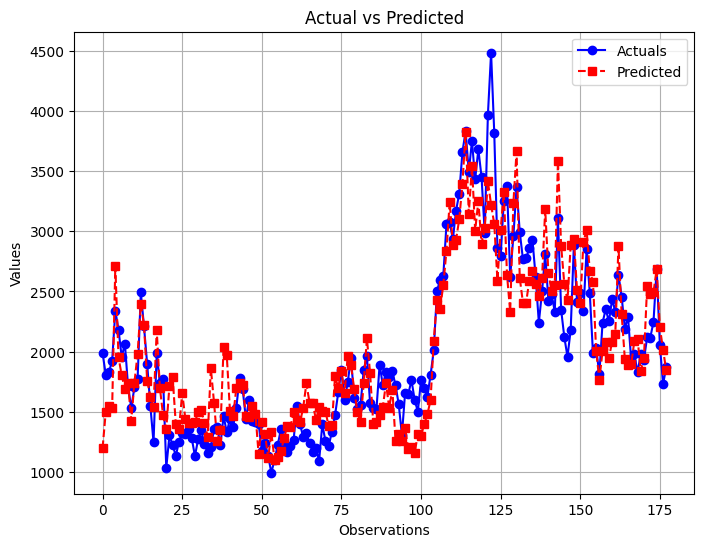

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(y, label='Actuals', marker='o', linestyle='-', color='b')
plt.plot(predictions, label='Predicted', marker='s', linestyle='--', color='r')
plt.xlabel('Observations')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

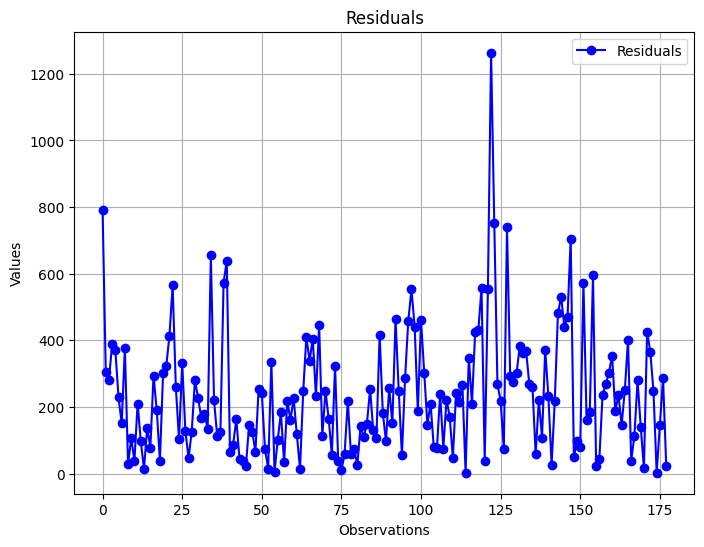

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(np.abs(predictions - y), label='Residuals', marker='o', linestyle='-', color='b')
plt.xlabel('Observations')
plt.ylabel('Values')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(f'Intercept: {clf.intercept_ * len(y) / predictions.sum()}')
print(f'Feature 1: {contributions[:, 0].sum() / predictions.sum()}')
print(f'Feature 2: {contributions[:, 1].sum() / predictions.sum()}')
print(f'Feature 3: {contributions[:, 2].sum() / predictions.sum()}')
print(f'Feature 4: {contributions[:, 3].sum() / predictions.sum()}')
print(f'Feature 5: {contributions[:, 4].sum() / predictions.sum()}')

Intercept: -0.14110344693812682
Feature 1: 0.13552980895204791
Feature 2: -0.062188235079029014
Feature 3: 0.4157759726842201
Feature 4: 0.02817871468360046
Feature 5: 0.6238071856972872


In [10]:
# lift tests
# 01-05-2023 to 31-05-2023: 3512

In [11]:
lift_test = df[(df['week_ending'] >= "2023-05-01") & (df['week_ending'] <= "2023-05-31")]
lift_test["spend_social"].sum() * clf.coef_[2]

6068.441676834161

In [12]:
lift_test

,week_ending,spend_ppc_nb,spend_ppc_b,spend_social,imp_ppc_nb,imp_ppc_b,imp_social,clk_ppc_nb,clk_ppc_b,clk_social,imp_seo,clk_seo,demand,conversions
122,2023-05-07,59644.96,25924.81,147229.81,326300,37697,50858511,6518,8216,119541,456956,46393,80,4484
123,2023-05-14,55566.59,24122.29,128626.00,314345,36297,50718701,6227,8285,115370,420156,44156,86,3815
124,2023-05-21,45098.39,22712.39,101575.81,295725,34124,31817581,5442,7769,79822,417786,41795,82,2858
125,2023-05-28,80538.11,26878.35,115394.81,313885,36241,36467501,6797,9631,95692,415914,43069,82,2792


# MMM

In [44]:
positive_indices = np.array([1, 2, 3, 4, 5])
negative_indices = np.array([])
reg_alpha = 0.1

model = TrainMMM(
    X=X,
    y=y,
    reg_alpha=reg_alpha,
    positive_indices=positive_indices,
    negative_indices=negative_indices,
    adstock_rate=0.0,
    hill_alpha=0.1,
    hill_gamma=0.5,
)

optimized_coef = model.train()
predictions = model.predict()
contributions = model.calculate_contributions()
    
print("Optimized coefficients:", optimized_coef)

Optimized coefficients: [-3.52330774e+02  7.51081833e-03  3.98691486e-10  1.20568850e-02
  7.89079553e-05  1.62345496e+01]


In [42]:
print(f'Intercept: {round(contributions[:, 0].sum() / predictions.sum(), 2)}')
print(f'Feature 1: {round(contributions[:, 1].sum() / predictions.sum(), 2)}')
print(f'Feature 2: {round(contributions[:, 2].sum() / predictions.sum(), 2)}')
print(f'Feature 3: {round(contributions[:, 3].sum() / predictions.sum(), 2)}')
print(f'Feature 4: {round(contributions[:, 4].sum() / predictions.sum(), 2)}')
print(f'Feature 5: {round(contributions[:, 5].sum() / predictions.sum(), 2)}')

Intercept: -0.18
Feature 1: 0.13
Feature 2: 0.0
Feature 3: 0.41
Feature 4: 0.01
Feature 5: 0.62


In [43]:
round(model.calculate_r2_score(), 2)

0.82

In [59]:
positive_indices = np.array([1, 2, 3, 4, 5])
negative_indices = np.array([])
reg_alpha = 0.1

def objective(params):

    model = TrainMMM(
        X=X,
        y=y,
        reg_alpha=reg_alpha,
        positive_indices=positive_indices,
        negative_indices=negative_indices,
        adstock_rate=params['adstock_rate'],
        hill_alpha=0.1,
        hill_gamma=0.5,
    )
    
    model.train()
    model.predict()
    score = -model.calculate_r2_score()
    
    return score

space = {
    'adstock_rate': hp.uniform('adstock_rate', 0.0, 1.0)
}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=6,
    trials=trials
)

print("Best parameters found: ", best)

  0%|          | 0/6 [00:00<?, ?trial/s, best loss=?]

job exception: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.



 83%|████████▎ | 5/6 [00:00<00:00, 69.15trial/s, best loss: -0.8325791845694077]


SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.